C:\Users\ICN_admin\Anaconda3\lib\site-packages\bids\layout\models.py:152: FutureWarning: The 'extension' entity currently excludes the leading dot ('.'). As of version 0.14.0, it will include the leading dot. To suppress this warning and include the leading dot, use `bids.config.set_option('extension_initial_dot', True)`.
  FutureWarning)


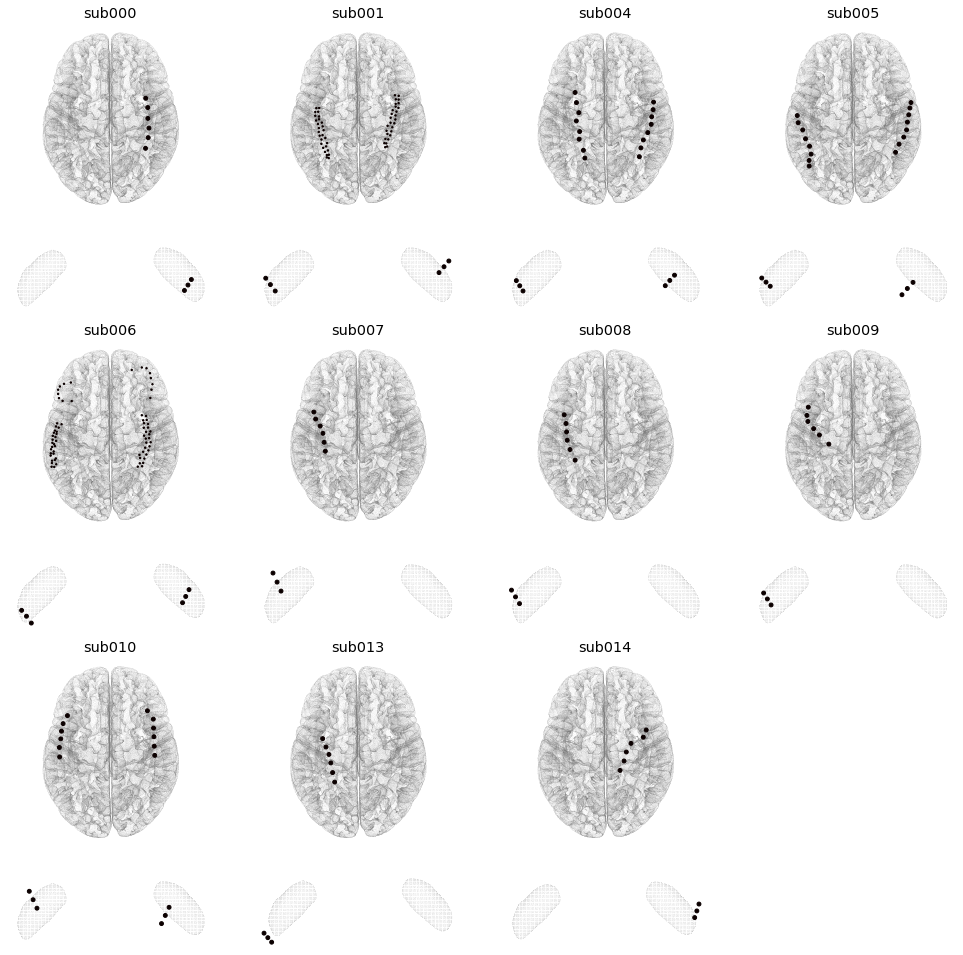

In [5]:
import os
import sys
import numpy as np 
import pandas as pd
from scipy import stats, signal, io
import mne
from mne import create_info, EpochsArray
from mne.time_frequency import tfr_morlet
from bids import BIDSLayout
import mne_bids
import scipy
import json
from sklearn import linear_model, metrics
import multiprocessing
from sklearn.model_selection import cross_val_score
from sklearn import ensemble, model_selection
from matplotlib import pyplot as plt
import matplotlib 

font = {'size'   : 12}
matplotlib.rc('font', **font)

PLT_SUPPLEMENTS_PATH = r'C:\Users\ICN_admin\Documents\ECOGVSTN\plot supplements'

# read plotting mat structures 
faces = io.loadmat(os.path.join(PLT_SUPPLEMENTS_PATH, 'faces.mat'))
Vertices = io.loadmat(os.path.join(PLT_SUPPLEMENTS_PATH, 'Vertices.mat'))
grid = io.loadmat(os.path.join(PLT_SUPPLEMENTS_PATH, 'grid.mat'))['grid']
stn_surf = io.loadmat(os.path.join(PLT_SUPPLEMENTS_PATH, 'STN_surf.mat'))
x_ = stn_surf['vertices'][::2,0]
y_ = stn_surf['vertices'][::2,1]
x_ecog = Vertices['Vertices'][::1,0]
y_ecog = Vertices['Vertices'][::1,1]
x_stn = stn_surf['vertices'][::1,0]
y_stn = stn_surf['vertices'][::1,1]

BIDS_PATH = r'C:\Users\ICN_admin\Documents\ECOGVSTN\data\BIDS_PITTSBURGH'

# from the BIDS Path Pittsburgh Gripforce we're only using a subset of patients
subject_id = ['000', '001', '004', '005', '006', '007', '008', '009', '010', '013', '014']

#002 - DBS4011 - no locaization possible
#003 - DBS4020 - LEFT due to signal quality
#011 - DBS4037 - STN was not recorded
#012 - DBS4030 - GPi not STN 
#015 - DBS4065 - LEFT due to signal quality

# read from BIDS all electrode data 

# path to icn_bids
sys.path.insert(1, r'C:\Users\ICN_admin\Documents\icn\icn_bids')
sys.path.insert(1, r'C:\Users\ICN_admin\Documents\icn')

import icn_bids

def plot_all_electrodes(BIDS_PATH, bids_layout):
    height_STN = 1
    height_ECOG = 2.5*height_STN
    
    rows=6; columns = 4
    
    fig, axes = plt.subplots(rows,columns, facecolor=(1,1,1), gridspec_kw={'height_ratios': [height_ECOG, height_STN]*3}, \
                             figsize=(17,17))#, dpi=700)
    x_cnt_ECOG, y_cnt_ECOG, x_cnt_STN, y_cnt_STN = 0,0,0,1

    for sub_idx, subject_id_ in enumerate(subject_id):    

        axes[y_cnt_ECOG, x_cnt_ECOG].scatter(x_ecog, y_ecog, c="gray", s=0.0001)
        axes[y_cnt_ECOG, x_cnt_ECOG].set_title('sub'+subject_id_, color='black')
        axes[y_cnt_ECOG, x_cnt_ECOG].set_axis_off()
        df_coord = icn_bids.get_electrodes(sub=subject_id_, ch_type="ECOG", space="mni", \
                                        layout=bids_layout, bids_path=BIDS_PATH)[["x", "y"]]*1000
        
        c = np.ones(df_coord.shape[0])
        
        if subject_id_ == '001' or subject_id_ == '006': # smaller size
            pos_ecog = axes[y_cnt_ECOG, x_cnt_ECOG].scatter(df_coord["x"], df_coord["y"], c=c, s=2, cmap='hot')
        else:
            pos_ecog = axes[y_cnt_ECOG, x_cnt_ECOG].scatter(df_coord["x"], df_coord["y"], c=c, s=15, cmap='hot')
        cbar_ecog = fig.colorbar(pos_ecog, ax=axes[y_cnt_ECOG, x_cnt_ECOG]); pos_ecog.set_clim(1,1.4); cbar_ecog.remove()
        
        df_coord = icn_bids.get_electrodes(sub=subject_id_, ch_type="SEEG", \
                                           layout=bids_layout, space="mni", bids_path=BIDS_PATH)[["x", "y"]]*1000
        pos_stn = axes[y_cnt_STN, x_cnt_STN].scatter(x_stn, y_stn, c="gray", s=0.0001)

        if subject_id_ not in ['012', '003']:

            c = np.ones(df_coord.shape[0])
            if subject_id_ == '016':
                pos_stn = axes[y_cnt_STN, x_cnt_STN].scatter(df_coord["x"], df_coord["y"], c=c, s=10, cmap='hot')
            else:
                pos_stn = axes[y_cnt_STN, x_cnt_STN].scatter(df_coord["x"], df_coord["y"], c=c, s=15, cmap='hot')
        cbar_stn = fig.colorbar(pos_stn, ax=axes[y_cnt_STN, x_cnt_STN]); pos_stn.set_clim(1,1.4); cbar_stn.remove()

        axes[y_cnt_STN, x_cnt_STN].axes.set_aspect('equal', anchor='C')
        axes[y_cnt_STN, x_cnt_STN].set_facecolor((1,1,1))
        axes[y_cnt_STN, x_cnt_STN].set_axis_off()
        axes[y_cnt_ECOG, x_cnt_ECOG].axes.set_aspect('equal', anchor='C')
        axes[y_cnt_ECOG, x_cnt_ECOG].set_facecolor((1,1,1))

        x_cnt_ECOG = x_cnt_ECOG + 1
        x_cnt_STN = x_cnt_ECOG

        if x_cnt_ECOG == 4:
            y_cnt_ECOG = y_cnt_ECOG + 2
            y_cnt_STN = y_cnt_ECOG + 1
            x_cnt_ECOG, x_cnt_STN = 0, 0

    axes[4, 3].set_facecolor((1,1,1)); axes[4, 3].set_axis_off()
    axes[5, 3].set_facecolor((1,1,1)); axes[5, 3].set_axis_off()
    #axes[6, 3].set_facecolor((1,1,1)); axes[6, 3].set_axis_off()
    #axes[7, 1].set_facecolor((1,1,1)); axes[7, 1].set_axis_off()
    #axes[7, 2].set_facecolor((1,1,1)); axes[7, 2].set_axis_off()
    #axes[7, 3].set_facecolor((1,1,1)); axes[7, 3].set_axis_off()
    
    fig.savefig("Figure_1.png")
    
layout = BIDSLayout(BIDS_PATH)
plot_all_electrodes(BIDS_PATH, layout)


In [2]:
import numpy as np
np.mean([28,8,8,8+28,6,6,6,6,6,6,28,8,8,28+8, 6, 6, 0,0,0,0,0,0])

9.454545454545455

In [3]:
np.std([28,8,8,8+28,6,6,6,6,6,6,28,8,8,28+8, 6, 6, 0,0,0,0,0,0])

11.154808472856706